# NVIDIA Data Visualization


In [125]:
# use alpaca as data api 
import os 
from typing import List
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as K 
import matplotlib.pyplot as plt 
from io import StringIO

from matplotlib.pyplot import figure
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

import yaml
import redis
import json
import pyarrow as pa

def acquire_credentials(secret_path: str = None):
    """
    looks for the credentials in a secret file
    """
    if secret_path is None:
        secret_path = PATH_SECRETS
    else:
        pass

    if os.path.exists(secret_path):

        # open file to secrets
        with open(secret_path, "r") as f:

            # use yaml to safely load
            key_information = yaml.safe_load(f)
            return key_information["api_key"], key_information["api_secret"]

    else:
        logger.critical("Secrets file not found")
        raise FileNotFoundError(f"File not found for {secret_path}")


In [126]:
# download data functions 

def download_data(secrets_path, start_date):
    """
    downloads data from the alpaca 
    """
    api_key , api_secret = acquire_credentials(secrets_path)

    client = StockHistoricalDataClient(api_key=api_key,
                                       secret_key=api_secret)

    request_params = StockBarsRequest(
        symbol_or_symbols="NVDA",
        timeframe=TimeFrame.Day,
        start=datetime.strptime(start_date, '%Y-%m-%d')
    )

    bars = client.get_stock_bars(request_params)
    df = bars.df 
    timestamps = df.index.map(lambda x : x[1]).values
    closing_prices = df['close'].values

    interim_df = pd.DataFrame({'timestamp':timestamps, 
                               'price': closing_prices})
    
    return interim_df        

In [127]:
SECRETS_PATH = "../src/.secrets"
START_DATE = "2024-01-04"

In [128]:
df = download_data(SECRETS_PATH, START_DATE)

In [129]:
# save raw data to redis 
connection =  redis.Redis(host='red', port=6379)

In [130]:
# stock list 

stock_list = connection.get('_STOCKS')

if stock_list is None:
    connection.set('_STOCKS', json.dumps(['NVDA']))
else:
    stock_list = json.loads(stock_list)
    if 'NVDA' not in stock_list:
        stock_list.append('NVDA')
        connection.set('_STOCKS', json.dumps(stock_list))


In [131]:
df_json = df.to_json()

In [132]:
connection.set('_NVDA', json.dumps({
    '2024-01-04/present':['table',df_json]
}))

True

In [133]:
connection.exists('_STOCKS')

1

In [134]:
df_new = pd.read_json(StringIO(json.loads(connection.get('_NVDA'))['2024-01-04/present'][1]))

In [135]:
class RedisTableUtility:

    def __init__(self, connection):
        self.connection = connection

    def check(self, key, date_key):
        if connection.exists(key):
            try:
                result = json.loads(connection.get(key))[date_key]
                return result[0] == 'table'
            except:
                return False
        else:
            return False

    def get(self, key, date_key):
        if self.check(key, date_key):
            
            result = json.loads(connection.get(key))[date_key]

            return pd.read_json(StringIO(result[1]))
        else:
            raise Exception(f"key:{key}{date_key} not found")
            
    def set(self, key, date_key, df_inbound):
        try:
            df_json = df_inbound.to_json()

            result = connection.set(key, 
                json.dumps({
                    date_key:['table', df_json]}
                          ))

            return result
        except:
            raise Exception(f"key:{key}{date_key} failed to set")

In [136]:
red_table = RedisTableUtility(connection)

In [137]:
red_table.check('_NVDA', '2024-01-04/present')

True

In [138]:
table = red_table.get('_NVDA', '2024-01-04/present')

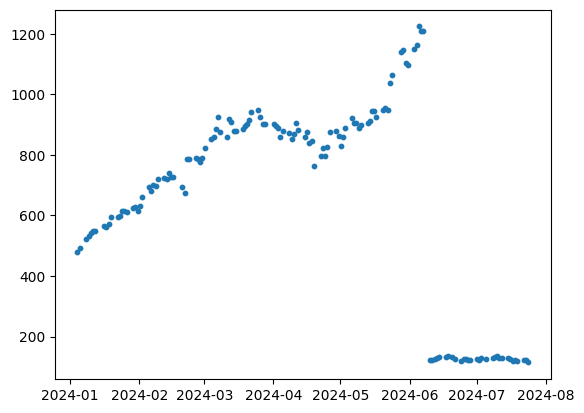

In [140]:
plt.scatter(df['timestamp'],df['price'], s=10)

In [141]:

close = df['price'].values
timestamps = df['timestamp'].values

try: 
    datetime_array = np.array([datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in timestamps])
except: 
    datetime_array = np.array([datetime.strptime(str(date), '%Y-%m-%dT%H:%M:%S.%f000000') for date in timestamps])

stock_split_for_nvidia_date = datetime.strptime('2024-06-08','%Y-%m-%d')
split_check = datetime_array <= stock_split_for_nvidia_date


close[split_check] = close[split_check] / 10


In [142]:
df['price'] = close

In [146]:
red_table.set('_NVDA','2024-01-04/present', df)

True

In [147]:
table = red_table.get('_NVDA', '2024-01-04/present')

In [149]:
fig = go.Figure([go.Scatter(x=table['timestamp'], 
                            y=df['price'], mode='markers')])


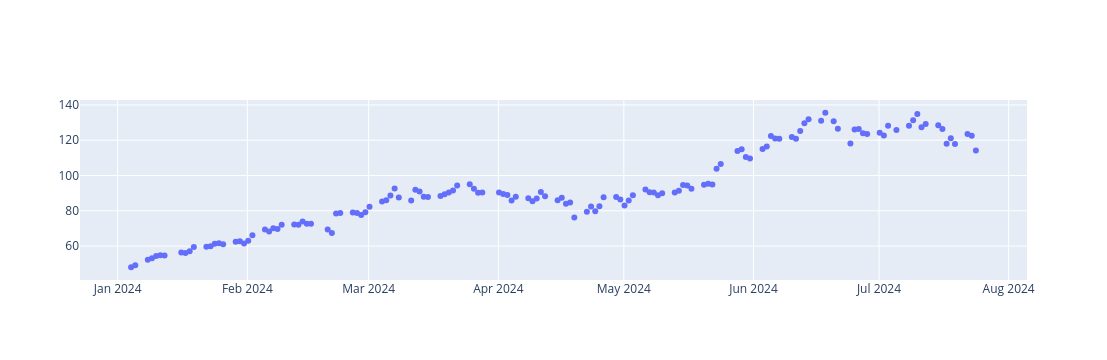

In [150]:
fig.show()